In [1]:
%run -i read_counts.py

False
None
./ALL_SAMPLES/
['./ALL_SAMPLES//dvh-output/Sample_ISB-1'
 './ALL_SAMPLES//dvh-output/Sample_ISB-10'
 './ALL_SAMPLES//dvh-output/Sample_ISB-11'
 './ALL_SAMPLES//dvh-output/Sample_ISB-12'
 './ALL_SAMPLES//dvh-output/Sample_ISB-13'
 './ALL_SAMPLES//dvh-output/Sample_ISB-14'
 './ALL_SAMPLES//dvh-output/Sample_ISB-15'
 './ALL_SAMPLES//dvh-output/Sample_ISB-16'
 './ALL_SAMPLES//dvh-output/Sample_ISB-17'
 './ALL_SAMPLES//dvh-output/Sample_ISB-18'
 './ALL_SAMPLES//dvh-output/Sample_ISB-19'
 './ALL_SAMPLES//dvh-output/Sample_ISB-2'
 './ALL_SAMPLES//dvh-output/Sample_ISB-20'
 './ALL_SAMPLES//dvh-output/Sample_ISB-21'
 './ALL_SAMPLES//dvh-output/Sample_ISB-22'
 './ALL_SAMPLES//dvh-output/Sample_ISB-23'
 './ALL_SAMPLES//dvh-output/Sample_ISB-24'
 './ALL_SAMPLES//dvh-output/Sample_ISB-3'
 './ALL_SAMPLES//dvh-output/Sample_ISB-4'
 './ALL_SAMPLES//dvh-output/Sample_ISB-5'
 './ALL_SAMPLES//dvh-output/Sample_ISB-6'
 './ALL_SAMPLES//dvh-output/Sample_ISB-7'
 './ALL_SAMPLES//dvh-output/Sample_

TypeError: exceptions must be old-style classes or derived from BaseException, not str

In [7]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
x = all_freqs['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sample_info = pd.read_excel('Sample_Info_COMPLETE.xlsx') ##,skiprows=[0])
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms
Sample name,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,NaN,37,D vulgaris Hildenborugh
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D vulgaris Hildenborugh
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0,37,D vulgaris Hildenborugh


In [4]:
%Rpush info
%Rpush x
genes = x.index.values.astype('str')
print(genes)
%Rpush genes
%R save.image("Untitled1.RData")

['DVU0001' 'DVU0002' 'DVU0003' ..., '__too_low_aQual' '__not_aligned'
 '__alignment_not_unique']


In [31]:
%%R
    load("Untitled1.RData")
    good_gene = which(!substr(genes,1,2)=='__' & apply(x,1,sum)>0)
    x = x[good_gene,]
    rownames(x)=genes[good_gene]
    x.orig = x = as.matrix(x)
    NULL

NULL


In [32]:
%%R
    x=log10(t(as.matrix(x)))
    x[is.na(x)|is.infinite(x)] <- 0
    x = t(scale(x))
    set.seed(10)
    km = kmeans(x,1000,20,200)

    x.scaled = x
    x = x.orig
    NULL

NULL


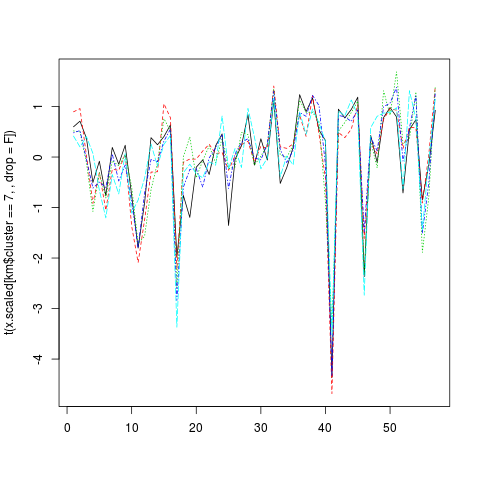

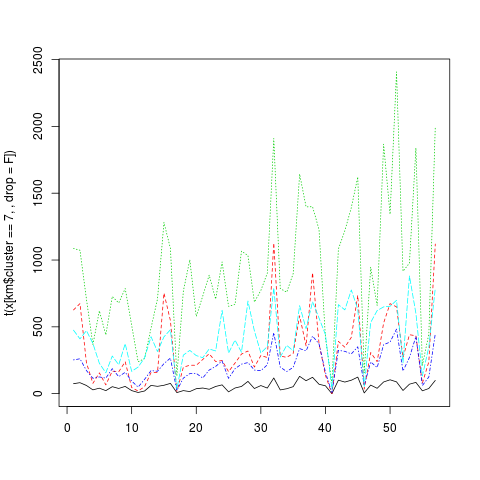

In [33]:
%R matplot(t(x.scaled[km$cluster==7,,drop=F]),typ='l')
%R matplot(t(x[km$cluster==7,,drop=F]),typ='l')

# Note I now think that we have to use all genes and use the non-centered-scaled data (ranked?) to do good classification.

Apparently whether the data is row-centered/scaled or not does not seem to significantly affect results, but it will if we use ranks.

In [12]:
%R require(randomForest)
#sizeme(info.head(3),50,120)

<Vector - Python:0x7fbedc9c5b48 / R:0x4b1db08>
[       1]

In [41]:
%R print(mean(x.scaled[1,]))
%R print(mean(x.orig[1,]))

[1] -1.644064e-16


[1] 97.92636


### Train classifier on growth rate


Call:
 randomForest(x = t(x), y = Y, ntree = 10000, importance = T,      do.trace = F) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 60

        OOB estimate of  error rate: 21.05%
Confusion matrix:
            fast_growth med_growth no_growth class.error
fast_growth          18          0         5  0.21739130
med_growth            1         11         0  0.08333333
no_growth             5          1        16  0.27272727
NULL


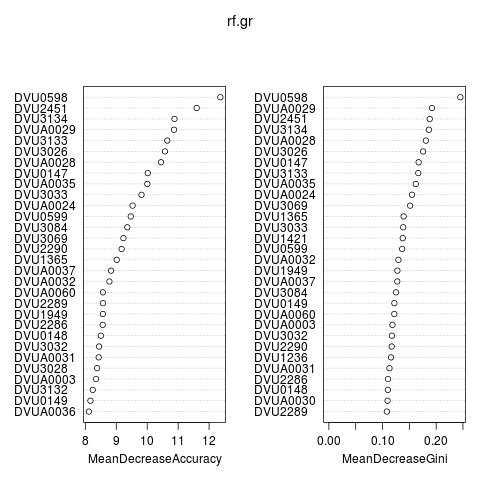

In [42]:
%%R
    gr=info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
    Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    #model.mat = model.matrix(~-1+cultivation.type+electron.donor+electron.acceptor+growth.rate.per.h+T0C,data=info)
    rf.gr <- randomForest(t(x), Y, importance=T, ntree=10000, do.trace=F)
    varImpPlot(rf.gr); print(rf.gr)


Call:
 randomForest(x = t(x.scaled), y = Y, ntree = 10000, importance = T,      do.trace = F) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 60

        OOB estimate of  error rate: 21.05%
Confusion matrix:
            fast_growth med_growth no_growth class.error
fast_growth          18          0         5  0.21739130
med_growth            1         11         0  0.08333333
no_growth             5          1        16  0.27272727
NULL


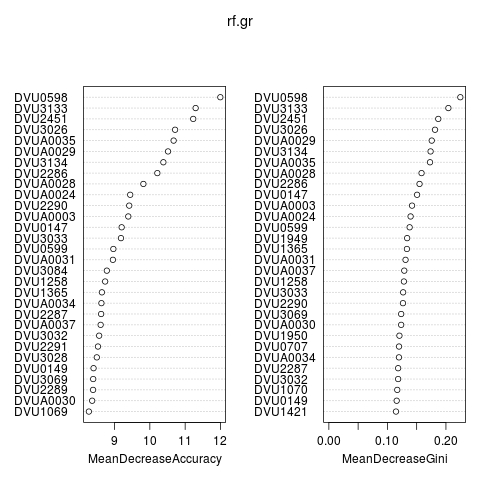

In [43]:
%%R
    gr=info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
    Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )
    #model.mat = model.matrix(~-1+cultivation.type+electron.donor+electron.acceptor+growth.rate.per.h+T0C,data=info)
    rf.gr <- randomForest(t(x.scaled), Y, importance=T, ntree=10000, do.trace=F)
    varImpPlot(rf.gr); print(rf.gr)

### submit selected genes to network portal to see function

In [14]:
%R imps <- rf.gr$importance; imps = imps[order(imps[,'MeanDecreaseAccuracy'], decreasing=T),]
%R imp_vars = rownames(imps)[1:25]
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU0598 DVUA0029 DVU3134 DVU3026 DVU2451 DVU3133 DVUA0035 DVUA0024 DVUA0028 DVU2286 DVU3033 DVU0599 DVUA0037 DVU1949 DVU0147 DVUA0003 DVU2290 DVUA0031 DVU3084 DVU3132 DVU3069 DVU0169 DVUA0032 DVU2289 DVU1258


### Train classifier on electron donor


Call:
 randomForest(x = t(x), y = Y, ntree = 10000, importance = T,      do.trace = F) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 60

        OOB estimate of  error rate: 1.75%
Confusion matrix:
         hydrogen lactate pyruvate class.error
hydrogen       12       0        0  0.00000000
lactate         0      33        0  0.00000000
pyruvate        1       0       11  0.08333333
NULL


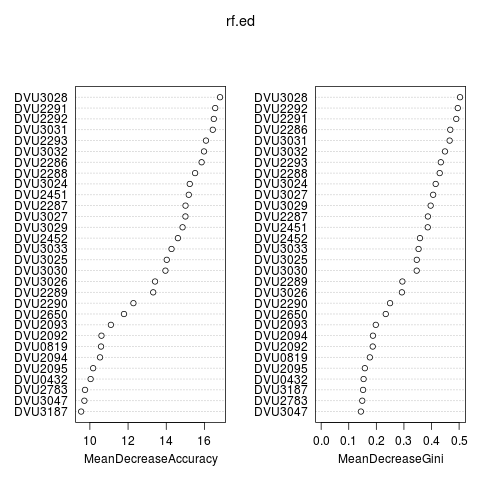

In [15]:
%%R
    Y <- info$electron.donor
    rf.ed <- randomForest(t(x), Y, importance=T, ntree=10000, do.trace=F)
    varImpPlot(rf.ed); print(rf.ed)

In [16]:
%R imps <- rf.ed$importance; imps = imps[order(imps[,'MeanDecreaseAccuracy'], decreasing=T),]
%R imp_vars = rownames(imps)[1:25]
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU3028 DVU2292 DVU2286 DVU2291 DVU3031 DVU3032 DVU2293 DVU3024 DVU3027 DVU3029 DVU2288 DVU2287 DVU2451 DVU3025 DVU3033 DVU2452 DVU3030 DVU3026 DVU2289 DVU2290 DVU2650 DVU2093 DVU0432 DVU2092 DVU2094


[1] "DVU3031" "DVU3032" "DVU2293" "DVU3024" "DVU3027" "DVU3029" "DVU2288"
[8] "DVU2287"


Y
hydrogen  lactate pyruvate 
      12       33       12 


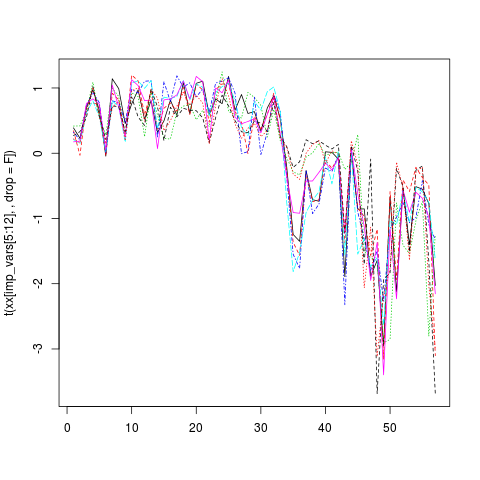

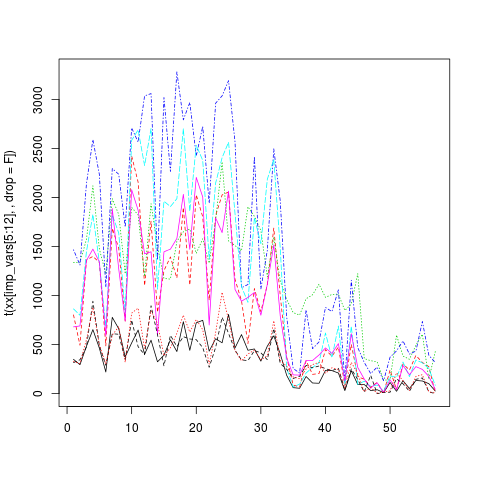

In [17]:
%R print(imp_vars[5:12])
%R print(table(Y))
%R xx=cbind(x[,Y=='lactate'],x[,Y=='pyruvate'],x[,Y=='hydrogen']); matplot(t(xx[imp_vars[5:12],,drop=F]),typ='l')
%R xx=cbind(x.orig[,Y=='lactate'],x.orig[,Y=='pyruvate'],x.orig[,Y=='hydrogen']); matplot(t(xx[imp_vars[5:12],,drop=F]),typ='l')

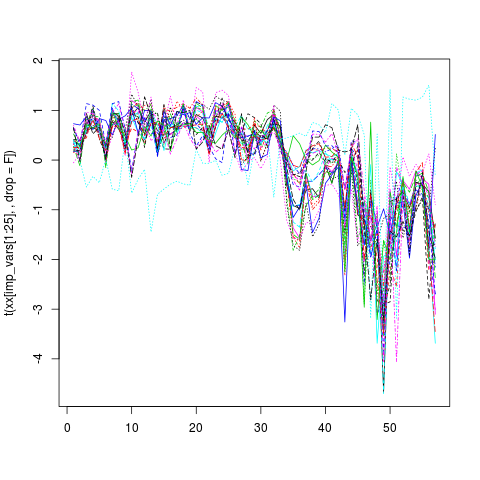

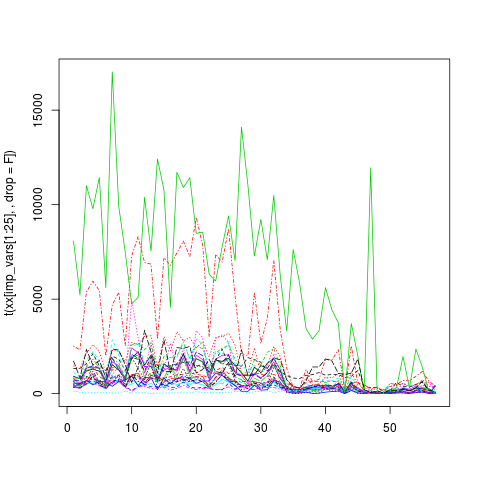

In [18]:
%R xx=cbind(x[,Y=='lactate'],x[,Y=='pyruvate'],x[,Y=='hydrogen']); matplot(t(xx[imp_vars[1:25],,drop=F]),typ='l')
%R xx=cbind(x.orig[,Y=='lactate'],x.orig[,Y=='pyruvate'],x.orig[,Y=='hydrogen']); matplot(t(xx[imp_vars[1:25],,drop=F]),typ='l')

OK, it looks like certain selected variables are highly similar, which is ok as randomForest does not try to minimize this. Let's try varSelRF to see what it does instead. 

In [19]:
%%R
    require(varSelRF)
    Y <- info$electron.donor
    vrf.ed <- varSelRF(t(x), Y, recompute.var.imp=T, ntree=10000, ntreeIterat=10000, c.sd=0.5, keep.forest=T, verbose=F)
    print(vrf.ed)

Loading required package: varSelRF
Loading required package: parallel

Backwards elimination on random forest; ntree =  10000 ;  mtryFactor =  1 

 Selected variables:
[1] "DVU2286" "DVU2292" "DVU2293" "DVU3028"

 Number of selected variables: 4 

NULL


### Train classifier on electron acceptor


Call:
 randomForest(x = t(x), y = Y, ntree = 10000, importance = T,      do.trace = F) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 60

        OOB estimate of  error rate: 12.28%
Confusion matrix:
                      none proton/hydrogenotroph sulfate class.error
none                    15                     0       3   0.1666667
proton/hydrogenotroph    0                    21       0   0.0000000
sulfate                  4                     0      14   0.2222222
NULL


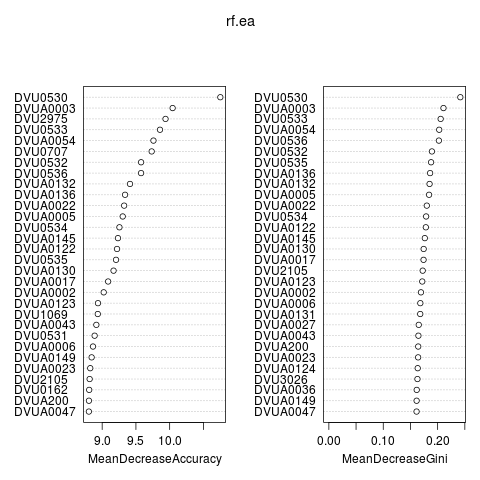

In [20]:
%%R
    Y <- info$electron.acceptor
    rf.ea <- randomForest(t(x), Y, importance=T, ntree=10000, do.trace=F)
    varImpPlot(rf.ea); print(rf.ea)

In [24]:
%R imps <- rf.ea$importance; imps = imps[order(imps[,'MeanDecreaseAccuracy'], decreasing=T),]
%R imp_vars = rownames(imps)[1:25]
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVUA0003 DVU0530 DVU0533 DVUA0054 DVUA0022 DVUA0005 DVUA0145 DVUA0130 DVUA0122 DVUA0136 DVUA0132 DVUA0002 DVU0536 DVUA0027 DVU0532 DVUA0123 DVUA0112 DVUA0149 DVUA0017 DVUA0006 DVUA0043 DVUA0023 DVUA0131 DVU0535 DVUA0113


### Train classifier on temperature


Call:
 randomForest(x = t(x), y = Y, ntree = 10000, importance = T,      do.trace = F) 
               Type of random forest: regression
                     Number of trees: 10000
No. of variables tried at each split: 1211

          Mean of squared residuals: 0.06379048
                    % Var explained: 73.08
NULL


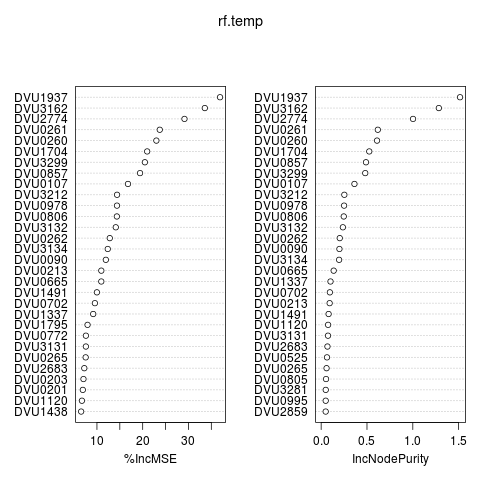

In [22]:
%%R
    Y <- info$T0C == 37
    rf.temp <- randomForest(t(x), Y, importance=T, ntree=10000, do.trace=F)
    varImpPlot(rf.temp); print(rf.temp)

In [23]:
%R imps <- rf.temp$importance; imps = imps[order(imps[,'%IncMSE'], decreasing=T),]
%R imp_vars = rownames(imps)[1:25]
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=150)

DVU1937 DVU3162 DVU2774 DVU0261 DVU0260 DVU1704 DVU3299 DVU0857 DVU0107 DVU3132 DVU0978 DVU3212 DVU0806 DVU3134 DVU0262 DVU0090 DVU0665 DVU0702 DVU1337 DVU0213 DVU1491 DVU3131 DVU2683 DVU0265 DVU1795
